# Pokersters Fantasy Football Notebook
Lets do the data thang

In [2]:
%pip install sleeper-api-wrapper
%pip install matplotlib-label-lines

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


### Initialize

In [1]:
from sleeper_wrapper import League, Stats, Players
import pandas as pd
import numpy as np
import io
import csv
import re
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from labellines import labelLine, labelLines

league_id = 852044618987085824
league = League(league_id)
players = Players()
# players_df = pd.read_pickle('./sleeper_players.pkl')
# ffa_proj_df = pd.read_pickle("./ffa_proj.pkl")
plt.rcParams['figure.figsize'] = [20, 10]

In [63]:
# import player projection data from spreadsheet
projection_file = '2022_projections/2022_season_ff_projection.txt'

with open('sleeper_players.pkl', 'wb') as file:
    ffa_proj_df = pd.read_csv(projection_file, sep='\t', index_col=None)
    ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')
    ffa_proj_df['Player_Pos'] = ffa_proj_df['Player'] + ffa_proj_df['Position']
    # why is the abbr for vegas LVR rather than LV??? annoying
    ffa_proj_df['Team'].replace({'LVR': 'LV', 'JAC': 'JAX'}, inplace=True)
    # convert defense player names from common name to abbreviated to match sleeper
    ffa_proj_df.to_pickle('./ffa_proj.pkl')

ffa_proj_df.head()

C:\Users\andre\AppData\Local\Temp/ipykernel_5540/2843173688.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')


,Index,a,b,Position,Player,Team,Floor,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
0,1,NaN,NaN,RB,Jonathan Taylor,IND,263.000000,301.000000,332.000000,22.800000,37,150.000000,30.300000,1,NaN,NaN,Jonathan TaylorRB
1,2,NaN,NaN,RB,Derrick Henry,TEN,234.000000,270.000000,309.000000,25.400000,48,120.000000,23.300000,2,NaN,NaN,Derrick HenryRB
2,3,NaN,NaN,WR,Cooper Kupp,LAR,220.000000,237.000000,279.000000,7.020000,1,102.000000,22.400000,1,NaN,NaN,Cooper KuppWR
3,4,NaN,NaN,TE,Travis Kelce,KC,165.000000,184.000000,210.000000,8.170000,3,101.000000,15.900000,1,NaN,NaN,Travis KelceTE
4,5,NaN,NaN,RB,Austin Ekeler,LAC,223.000000,247.000000,273.000000,20.900000,32,96.700000,2.490000,2,NaN,NaN,Austin EkelerRB


In [64]:
# Import players from sleeper, run this block to get updated players data
players_dict = players.get_all_players()
players_df = pd.DataFrame(players_dict).transpose()
players_df['full_name'] = players_df['full_name'].str.replace('.', '')
players_df['full_name_pos'] = players_df['full_name'] + players_df['position']
players_df = players_df.reset_index()
players_df = players_df.merge(ffa_proj_df, left_on='full_name_pos', right_on='Player_Pos', how='left')
players_df['player_id'] = players_df['index'].fillna(players_df['Team'])
players_df = players_df.set_index('player_id')
players_df = players_df.drop(columns=['index'])
for i in players_df.loc[players_df['fantasy_positions'].apply(lambda x: True if x and 'DEF' in x else False).tolist()].index.tolist():
    dst_matches = ffa_proj_df[(ffa_proj_df['Position'] == 'DST') & (ffa_proj_df['Team'] == i)]
    if not dst_matches.empty:
        players_df.loc[i, ffa_proj_df.columns] = dst_matches.iloc[0]
players_df[ffa_proj_df.columns] = players_df[ffa_proj_df.columns].fillna(0)
players_df.to_pickle('./sleeper_players.pkl')
players_df.head()

C:\Users\andre\AppData\Local\Temp/ipykernel_5540/1579613147.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  players_df['full_name'] = players_df['full_name'].str.replace('.', '')


,rotoworld_id,rotowire_id,injury_start_date,birth_city,number,high_school,practice_description,depth_chart_order,gsis_id,injury_status,...,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
player_id,,,,,,,,,,,,,,,,,,,,,
2103,None,9866,None,None,60,None,None,None,None,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6250,None,None,None,None,0,Fort Dorchester,None,None,None,NA,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4116,12247,11794,None,None,0,Charles Drew (GA),None,None,00-0033922,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
8465,None,16062,None,None,74,Wagner (TX),None,1,None,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6177,None,13746,None,None,99,Parkway Central (MO),None,2,00-0035656,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [65]:
ffa_proj_df.head()

,Index,a,b,Position,Player,Team,Floor,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
0,1,NaN,NaN,RB,Jonathan Taylor,IND,263.000000,301.000000,332.000000,22.800000,37,150.000000,30.300000,1,NaN,NaN,Jonathan TaylorRB
1,2,NaN,NaN,RB,Derrick Henry,TEN,234.000000,270.000000,309.000000,25.400000,48,120.000000,23.300000,2,NaN,NaN,Derrick HenryRB
2,3,NaN,NaN,WR,Cooper Kupp,LAR,220.000000,237.000000,279.000000,7.020000,1,102.000000,22.400000,1,NaN,NaN,Cooper KuppWR
3,4,NaN,NaN,TE,Travis Kelce,KC,165.000000,184.000000,210.000000,8.170000,3,101.000000,15.900000,1,NaN,NaN,Travis KelceTE
4,5,NaN,NaN,RB,Austin Ekeler,LAC,223.000000,247.000000,273.000000,20.900000,32,96.700000,2.490000,2,NaN,NaN,Austin EkelerRB


### Get Leaguemates data

In [66]:
users = league.get_users()
users_df = pd.DataFrame(users)
users_df = users_df.set_index(users_df.columns[0])
users_df

,settings,metadata,league_id,is_owner,is_bot,display_name,avatar
user_id,,,,,,,
375038190341611520,None,"{'team_name': 'The Trolley Problems', 'mention...",852044618987085824,False,False,thinkfast86,3c7def417a4613d104ae66403af0e0e7
607043401484926976,None,{'mascot_item_type_id_leg_6': 'eggplant-emoji'...,852044618987085824,False,False,mmasison,e36c64e702e2db846c91eb439a13df6a
608864437348163584,None,"{'mascot_item_type_id_leg_6': 'pizza', 'mascot...",852044618987085824,False,False,TheVermanator,None
723630209273765888,None,"{'team_name': 'Hit Quads like Saquon', 'mentio...",852044618987085824,True,False,benslayer68,None
723633476015857664,None,"{'team_name': 'Waiting For 2023', 'mention_pn'...",852044618987085824,False,False,dlaffs,6e0dc0a80e7d0560d8ef4777d3a90b16
723650381690769408,None,"{'mascot_item_type_id_leg_6': 'trash', 'mascot...",852044618987085824,False,False,mikulis,ea2334c4e55f4c7d1d1544544eae3f54
723683736822059008,None,"{'mascot_item_type_id_leg_6': 'dogecoin', 'mas...",852044618987085824,True,False,schlaich,0008e9a0c13d1ebb16549afa8e884ef3
723753245457104896,None,"{'team_name': 'Hop on the Magic Gus Bus', 'men...",852044618987085824,False,False,izzyfoshizzy8,15d7cf259bc30eab8f6120f45f652fb6
723755503108349952,None,"{'mascot_item_type_id_leg_6': 'taco', 'mascot_...",852044618987085824,False,False,hunterm19,505a21249447d6533b5e1fc3dd53d755


In [98]:
rosters = league.get_rosters()
rosters_df = pd.DataFrame(rosters)
# if someone doesn't have a team name, use username
rosters_df['team_name'] = rosters_df['owner_id'].apply(lambda x: users_df.loc[x]['metadata']['team_name'] if 'team_name' in users_df.loc[x]['metadata'] else users_df.loc[x]['display_name'])

def get_bench(row):
    return [x for x in row['players'] if x not in row['starters']]

rosters_df['bench'] = rosters_df.apply(get_bench, axis=1)
rosters_df.head()

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,keepers,co_owners,team_name,bench
0,None,"[7610, 6130, 7608, 4068, 4037, 6126, 7606, 704...","{'wins': 0, 'waiver_position': 3, 'waiver_budg...",1,[8154],"[4037, 4068, 5917, 6126, 6130, 7042, 7591, 760...",None,723630209273765888,"{'streak': '2L', 'record': 'WWWWWLLLWWWWLWWWLW...",852044618987085824,[4068],None,Hit Quads like Saquon,"[5917, 7591, 7670, 8132, 8154, 8167, 8205]"
1,None,"[6904, 4098, 7607, 4039, 5872, 4217, 5045, 49,...","{'wins': 0, 'waiver_position': 4, 'waiver_budg...",2,None,"[4039, 4098, 4217, 49, 5045, 5872, 5987, 6805,...",None,375038190341611520,"{'streak': '4W', 'record': 'WWWLWWWLWLWWWWLLWW...",852044618987085824,"[4039, 5872]",None,The Trolley Problems,"[5987, 6805, 7594, 8121, 8144, 8153]"
2,None,"[4984, 3198, 4199, 2133, 1479, 5844, 5937, 608...","{'wins': 0, 'waiver_position': 11, 'waiver_bud...",3,None,"[1352, 1479, 1825, 2133, 2309, 2319, 3198, 419...",None,607043401484926976,"{'streak': '1L', 'record': 'WWLWLLLLWWLLLLLLWL...",852044618987085824,"[4984, 6806]",None,💩 King Henry,"[1352, 1825, 2309, 2319, 6806, 6828, 947]"
3,None,"[2028, 6938, 6820, 3321, 2197, 5001, 2374, 391...","{'wins': 0, 'waiver_position': 10, 'waiver_bud...",4,None,"[2028, 2197, 2374, 3225, 3321, 3664, 391, 4149...",None,723633476015857664,"{'streak': '1W', 'record': 'LLWLWWWWLWLLWWLLLL...",852044618987085824,[2197],None,Waiting For 2023,"[3225, 3664, 4149, 4951, 5086, 7567]"
4,None,"[6797, 5892, 1535, 2449, 4950, 1466, 7611, 466...","{'wins': 0, 'waiver_position': 1, 'waiver_budg...",5,None,"[1466, 1535, 2449, 3214, 4666, 4950, 5347, 589...",None,608864437348163584,"{'streak': '4L', 'restrict_pn_scoring_starters...",852044618987085824,[6797],None,Je Ne Saquon,"[3214, 5347, 5947, 6955, 7527, 8135]"


In [2]:
#  Post-draft VOR calculation
rosters_df['Starters_VOR'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))
rosters_df['Bench_VOR'] = rosters_df['bench'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))
rosters_df['Team_VOR'] = rosters_df['players'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))

ax = rosters_df.sort_values('Team_VOR')[['Starters_VOR', 'Bench_VOR', 'team_name']].plot.bar(x='team_name', stacked=True)
for container in ax.containers:
    ax.bar_label(container)

NameError: name 'rosters_df' is not defined

[Text(0, 0, '5.91'),
 Text(0, 0, '85.02'),
 Text(0, 0, '87.2'),
 Text(0, 0, '195.37'),
 Text(0, 0, '205.19'),
 Text(0, 0, '211.38'),
 Text(0, 0, '252.9'),
 Text(0, 0, '273.47'),
 Text(0, 0, '290.79'),
 Text(0, 0, '352.37'),
 Text(0, 0, '368.69'),
 Text(0, 0, '370.65')]

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)


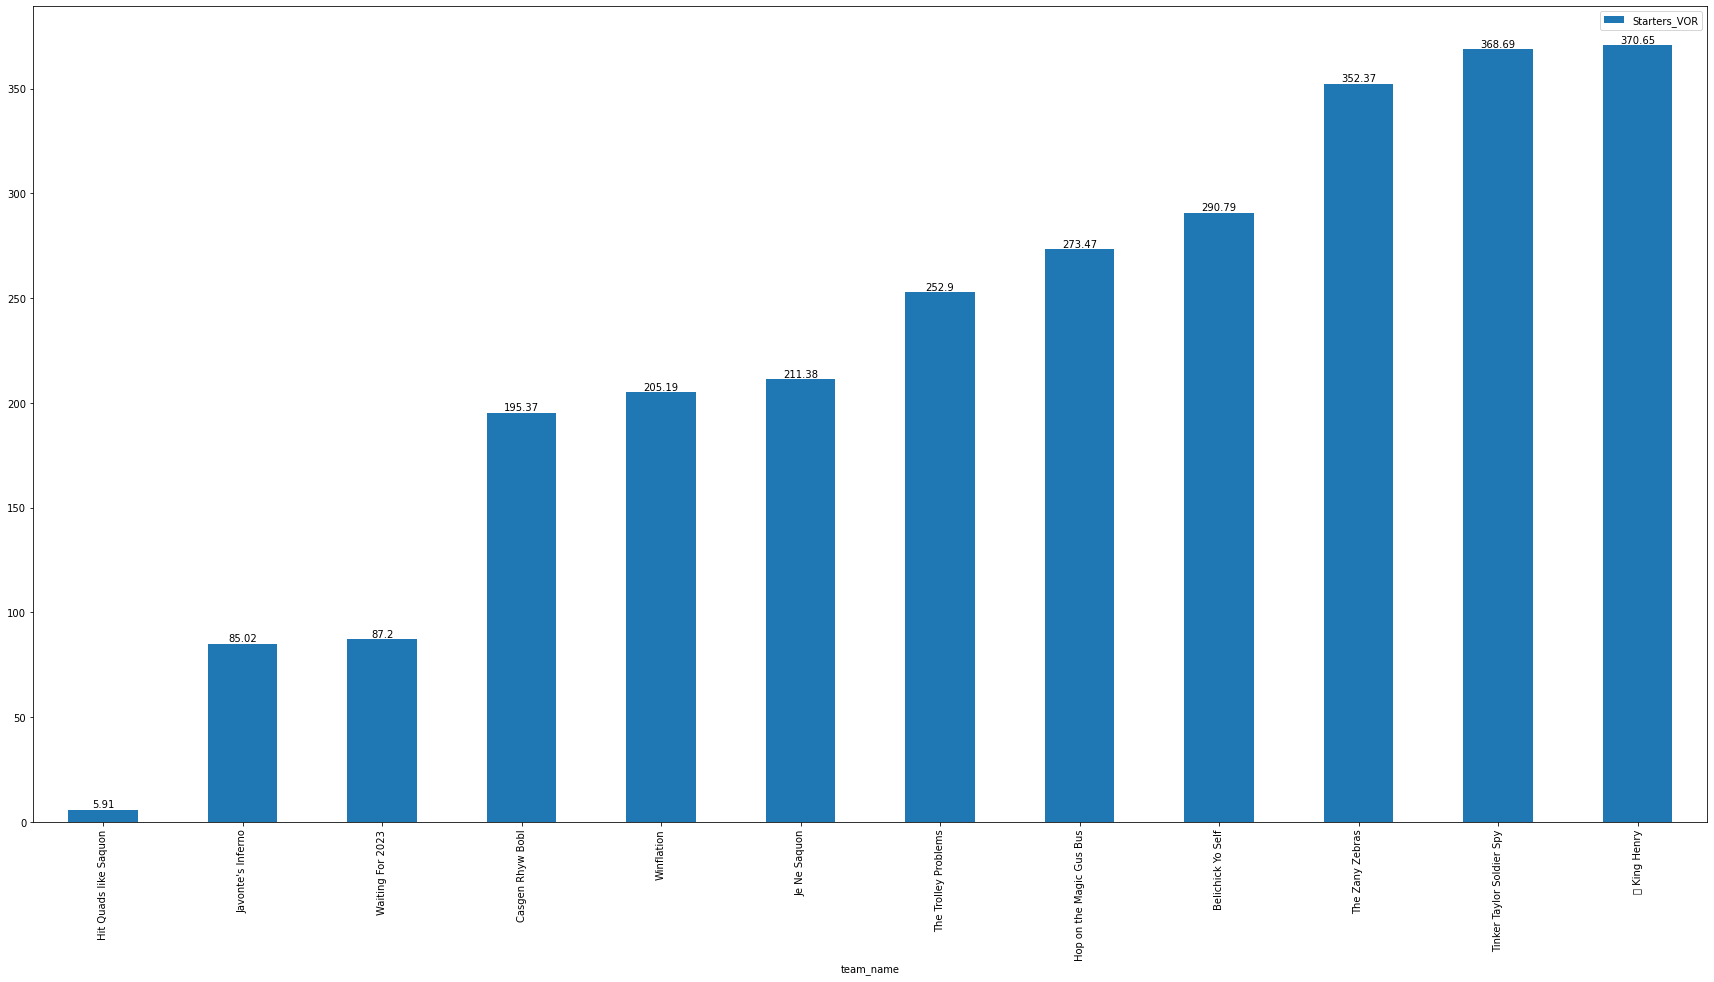

In [113]:
ax = rosters_df.sort_values('Starters_VOR').plot.bar(x='team_name', y='Starters_VOR')
ax.bar_label(ax.containers[0])


In [115]:
for col in ['Floor','Points','Ceiling','Uncertainty']:
    rosters_df['Starters_' + col] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']][col]))

rosters_df['Starters_Variance'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['SD']**2))
rosters_df['Starters_SD'] = rosters_df['Starters_Variance']**(1/2)

In [116]:
players_df.loc[[x for x in rosters_df.iloc[7]['starters'] if x != '0']].loc[:, ['full_name', 'Points', 'SD']]

,full_name,Points,SD
player_id,,,
96,Aaron Rodgers,317.000000,25.500000
4663,Austin Ekeler,247.000000,20.900000
4988,Nick Chubb,209.000000,25.900000
4983,DJ Moore,149.000000,10.600000
7525,DeVonta Smith,0.000000,0.000000
2505,Darren Waller,128.000000,9.200000
3164,Ezekiel Elliott,189.000000,16.400000
7062,Rodrigo Blankenship,0.000000,0.000000
LAR,NaN,94.400000,7.100000


[Text(0, 0, '570'),
 Text(0, 0, '605.3'),
 Text(0, 0, '894'),
 Text(0, 0, '1045'),
 Text(0, 0, '1083.4'),
 Text(0, 0, '1243.6'),
 Text(0, 0, '1333.4'),
 Text(0, 0, '1408.8'),
 Text(0, 0, '1528'),
 Text(0, 0, '1607'),
 Text(0, 0, '1691.7'),
 Text(0, 0, '1694.5')]

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)


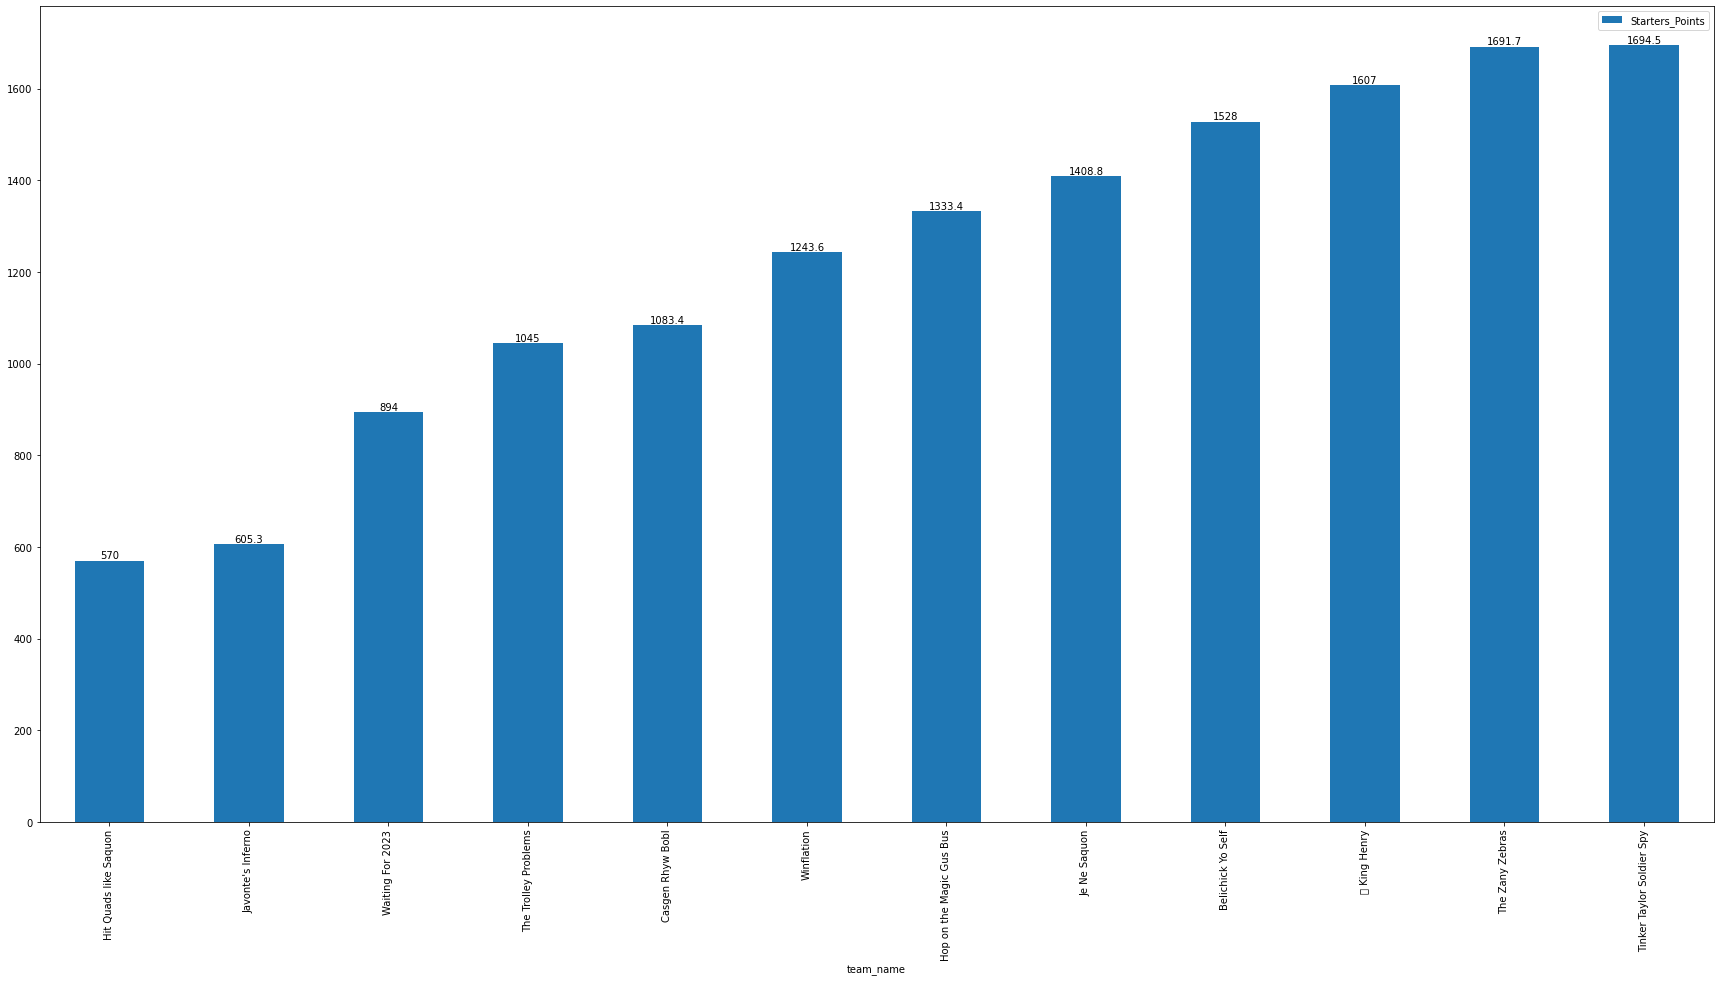

In [119]:
ax = rosters_df.sort_values('Starters_Points').plot.bar(x='team_name', y='Starters_Points')
ax.bar_label(ax.containers[0])


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)


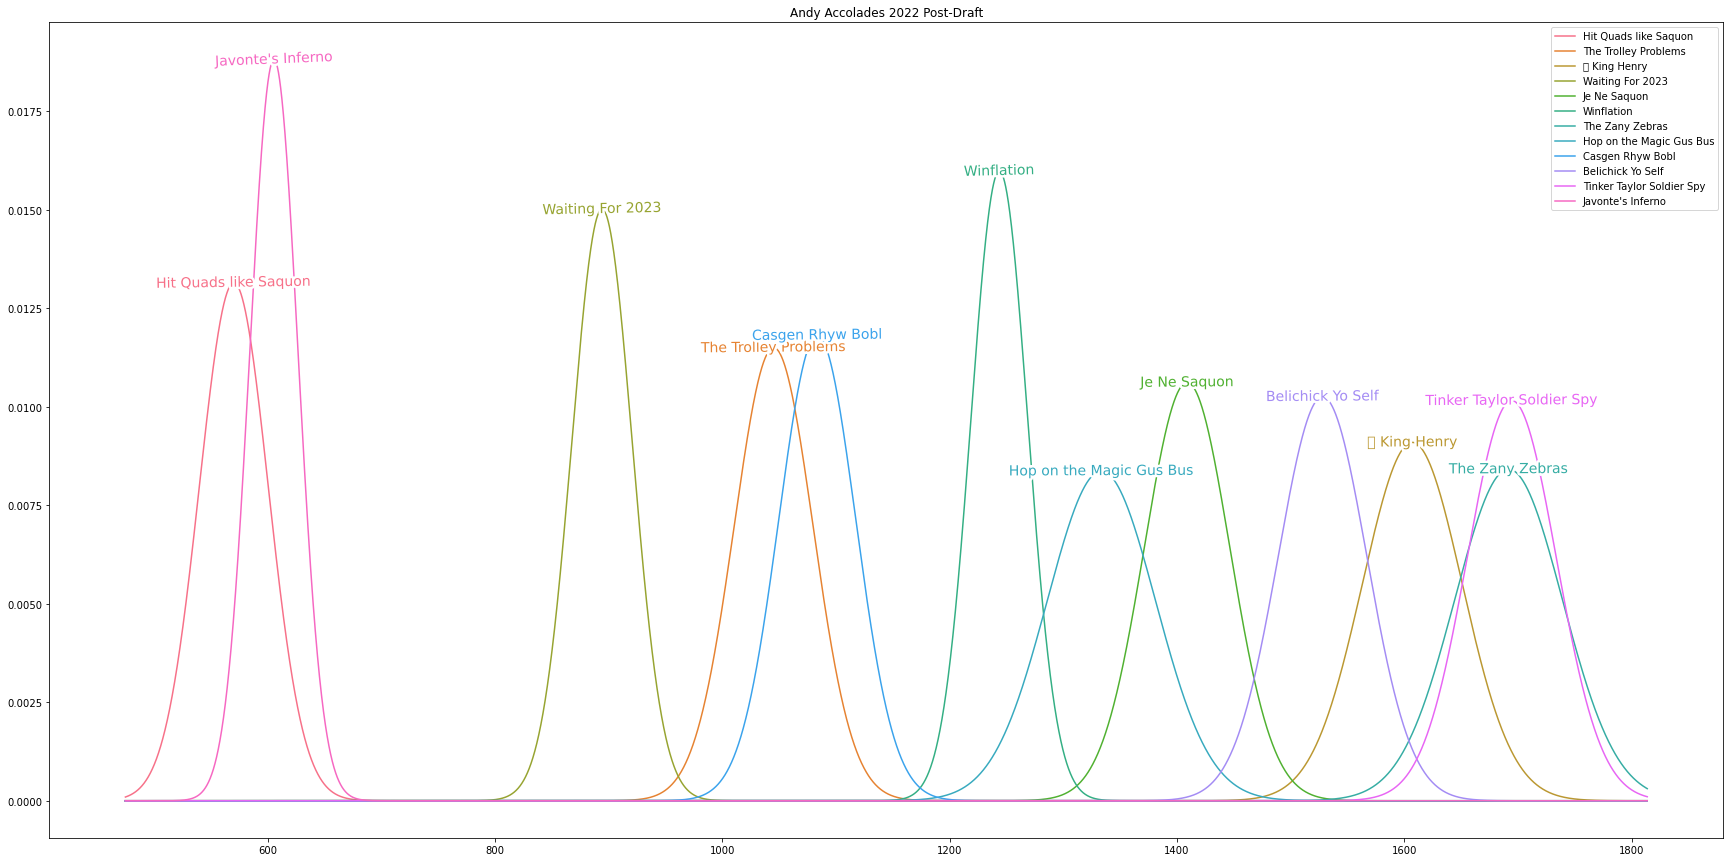

In [122]:
plt.rcParams['figure.figsize'] = [30, 15]
fig, ax1 = plt.subplots()
colors = sns.color_palette("husl", rosters_df.shape[0])
ax1.set_prop_cycle('color', colors)
x_axis = np.arange(rosters_df['Starters_Points'].min() - 2*rosters_df['Starters_SD'].max(), rosters_df['Starters_Points'].max() + 2.5*rosters_df['Starters_SD'].max(), .1)

for roster in rosters_df.iterrows():  
    plt.plot(x_axis, norm.pdf(x_axis, roster[1]['Starters_Points'], roster[1]['Starters_SD']), label=roster[1]['team_name'])
    
labelLines(plt.gca().get_lines(), fontsize=14, align=True,  xvals = rosters_df['Starters_Points'], zorder=2.5)
plt.legend()

ax1.title.set_text('Andy Accolades 2022 Post-Draft')
plt.show()

In [123]:
rosters_df.loc[:, ['team_name', 'Starters_Points', 'Starters_SD']].sort_values(by='Starters_Points')

,team_name,Starters_Points,Starters_SD
0,Hit Quads like Saquon,570.000000,30.345057
11,Javonte's Inferno,605.300000,21.204599
3,Waiting For 2023,894.000000,26.567190
1,The Trolley Problems,1045.000000,34.694445
8,Casgen Rhyw Bobl,1083.400000,33.770431
5,Winflation,1243.600000,24.962071
7,Hop on the Magic Gus Bus,1333.400000,47.688992
4,Je Ne Saquon,1408.800000,37.582661
9,Belichick Yo Self,1528.000000,38.903373
2,💩 King Henry,1607.000000,43.863068


In [124]:
rosters_df.loc[:, ['team_name', 'Starters_Ceiling', 'Starters_Floor']].sort_values(by='Starters_Ceiling')

,team_name,Starters_Ceiling,Starters_Floor
0,Hit Quads like Saquon,652.000000,465.000000
11,Javonte's Inferno,681.000000,550.600000
3,Waiting For 2023,1003.000000,829.000000
1,The Trolley Problems,1198.000000,939.000000
8,Casgen Rhyw Bobl,1214.300000,957.700000
5,Winflation,1368.000000,1152.400000
7,Hop on the Magic Gus Bus,1498.000000,1191.700000
4,Je Ne Saquon,1549.400000,1272.200000
9,Belichick Yo Self,1739.000000,1344.000000
2,💩 King Henry,1777.000000,1463.400000


In [125]:
week = 1
matchups = league.get_matchups(week)
matchups_df = pd.DataFrame(matchups)
mu = matchups_df.groupby('matchup_id')

In [126]:
num_matchups = len(rosters_df) // 2

matchup_prob_df = pd.DataFrame()


pd.set_option('display.float_format', '{:.6f}'.format)

for i in range(1, num_matchups+1):
    p1, p2 = mu.get_group(i)['roster_id'].iloc[0] - 1, mu.get_group(i)['roster_id'].iloc[1] - 1
    d_mean = rosters_df.iloc[p1]['Starters_Points'] - rosters_df.iloc[p2]['Starters_Points']
    d_var = rosters_df.iloc[p1]['Starters_Variance'] + rosters_df.iloc[p2]['Starters_Variance']
    # victory_prob = (1 - norm(d_mean, d_var**(1/2)).cdf(0))
    victory_prob = (1 - norm(d_mean, d_var).cdf(0))
    row = {'team1': rosters_df.iloc[p1]['team_name'], 'team2': rosters_df.iloc[p2]['team_name'], 'victory_probability': victory_prob, 'd_mean': d_mean, 'd_var': d_var}
    matchup_prob_df = matchup_prob_df.append(row, ignore_index=True)

print(matchup_prob_df.loc[:, ['team1', 'team2', 'victory_probability']])

                   team1                      team2  victory_probability
0  Hit Quads like Saquon  Tinker Taylor Soldier Spy             0.324027
1        The Zany Zebras           Casgen Rhyw Bobl             0.571236
2       Waiting For 2023          Belichick Yo Self             0.387563
3           💩 King Henry   Hop on the Magic Gus Bus             0.525981
4             Winflation          Javonte's Inferno             0.724084
5   The Trolley Problems               Je Ne Saquon             0.444702
